# **Load Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import random
import os
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [3]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.callbacks import EarlyStopping
from keras import optimizers

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Data**

In [5]:
!cp '/content/drive/MyDrive/CMIP6_Article/monthly_cmip6_temp/monthly_SHAHREKORD.csv' 'data.csv'

In [6]:
data = pd.read_csv('data.csv')

In [7]:
data.dropna(inplace=True)
# data

In [8]:
df = pd.DataFrame(data.corr().obs.sort_values(ascending=False)).drop(['month', 'year', 'obs'])
top_lst = list(df.index)[0:4]
top_lst

['MIROC6', 'CMC-ESM2', 'UKESM-0-LL', 'KACE-1-0-G']

In [9]:
def norm(df):
  norm_df = pd.DataFrame()
  for index, name in enumerate(list(df)):
    col = (df[name]-df[name].min())/(df[name].max()-df[name].min())
    norm_df.insert(index, name, col)
  # norm_df.insert(0, 'year', df.year)
  # norm_df.insert(1, 'month', df.month)
  return norm_df

In [10]:
norm_x = norm(data[top_lst])

# **Create some Noises in dataset**

In [ ]:
import numpy as np
mu, sigma = 0, 0.1
noise = np.random.normal(mu, sigma, np.array(data.shape))
noisy_target = data + noise
noisy_target[noisy_target <0] = 0

# **Linear Scaling**

In [ ]:
def linear_scaling_BC(obs, hst, average_obs, average_hst):
  corrected_hst = hst * (average_obs / average_hst)
  return corrected_hst

In [ ]:
data.obs.mean()

16.80410269191291

In [ ]:
names = list(data.columns[3:])

In [ ]:
BC = pd.DataFrame()
for index , name in enumerate(names):
   BC.insert(index, name, linear_scaling_BC(data.obs,data[name], data.obs.mean(), data[name].mean()))

In [ ]:
BC_df = BC.copy()
BC_df.insert(0, 'obs', data.obs)
BC_df

In [ ]:
sns.set(font='serif')
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=0.9)

from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 16
sns.heatmap(BC_df.corr(), annot=True, cmap='Blues')

In [ ]:
BC_df.insert(0, 'month', data.month)
BC_df.insert(0, 'year', data.year)
df = pd.DataFrame(BC_df.corr().obs.sort_values(ascending=False)).drop(['month', 'year', 'obs'])
top_lst = list(df.index)[0:10]
top_lst

['CMC-ESM2',
 'MIROC6',
 'INM-CM5-0',
 'INM-CM4-8',
 'GFDL-ESM4',
 'ACESS-ESM1-5',
 'KACE-1-0-G',
 'KIOST-EM',
 'MPI-ESM1-2-LR',
 'CMC-CM2-SR5']

# **Quantile Mapping (deltaQM)**

In [ ]:
import numpy as np
from scipy.stats import percentileofscore

def eQM_delta(ref_dataset, model_present):

        model_present_corrected = np.zeros(model_present.size)
        # model_future_corrected = np.zeros(model_future.size)

        for ival, model_value in enumerate(model_present):
            percentile = percentileofscore(model_present, model_value)
            model_present_corrected[ival] = np.percentile(ref_dataset, percentile)

        # for ival, model_value in enumerate(model_future):
        #     percentile = percentileofscore(model_future, model_value)
        #     model_future_corrected[ival] = model_value + np.percentile(
        #         ref_dataset, percentile) - np.percentile(model_present, percentile)
        return model_present_corrected
        # , model_future_corrected

In [ ]:
deltaQM = pd.DataFrame()
for index , name in enumerate(names):
  # print(name , index)
  deltaQM.insert(index, name, eQM_delta(data.obs,data[name]))

In [ ]:
deltaQM.insert(0, 'obs', data.obs)
deltaQM.insert(0, 'month', data.month)
deltaQM.insert(0, 'year', data.year)
df = pd.DataFrame(deltaQM.corr().obs.sort_values(ascending=False)).drop(['month', 'year', 'obs'])
top_lst = list(df.index)[0:10]
top_lst

['UKESM-0-LL',
 'NorESM2-MM',
 'CNRM-CM6-1',
 'ACCESS-CM2',
 'GISS-E2-1-G',
 'MRI-ESM2',
 'GFDL-ESM4',
 'INM-CM5-0',
 'HadGEM3-GC31-LL',
 'ACESS-ESM1-5']

# **PCA**

In [11]:
x = data.drop(['month', 'year', 'obs'], axis=1)
y = data.obs

In [12]:
from sklearn.decomposition import PCA


pca = PCA(n_components=5)
X_pca = pca.fit(x)
X_pca = pca.transform(x)
print("original shape:   ", x.shape)
print("transformed shape:", X_pca.shape)

original shape:    (336, 29)
transformed shape: (336, 5)


# **Model**

In [15]:
x.columns

Index(['CNRM-CM6-1', 'CanESM5', 'HadGEM3-GC31-LL', 'FGOALS-g3', 'BCC-CSM2-MR',
       'GISS-E2-1-G', 'MRI-ESM2', 'MIROC6', 'CESM2', 'IPSL-CM6A-LR',
       'UKESM-0-LL', 'TaiESM1', 'NorESM2-MM', 'NorEMS2-LM', 'NESM3',
       'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'KIOST-EM', 'KACE-1-0-G', 'INM-CM5-0',
       'INM-CM4-8', 'IITM-ESM', 'GFDL-ESM4', 'EC-Earth3-Veg-LR', 'EC-Earth3',
       'CMC-CM2-SR5', 'CMC-ESM2', 'ACESS-ESM1-5', 'ACCESS-CM2'],
      dtype='object')

In [16]:
x = x[top_lst]

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(x)
X = pd.DataFrame(X)

In [18]:
# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(degree = 3)
# X_degree3 = poly.fit_transform(x)

In [19]:
def LR_model(x, y, testsize):
  eval = pd.DataFrame()
  for TestSize in testsize:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TestSize, random_state=59)
    model =LinearRegression()
    model.fit(x_train , y_train)
    y_pred = model.predict(x_test)
    pr,_ = pearsonr(y_test, y_pred)
    sr,_ = spearmanr(y_test, y_pred)

    eval_dict = {'test size': TestSize,
                 'MAE': '%.3f' %  metrics.mean_absolute_error(y_test, y_pred),
                 'MSE': '%.3f' % metrics.mean_squared_error(y_test, y_pred),
                 'RMSE': '%.3f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
                 'R2 Score': '%.3f' % metrics.r2_score(y_test, y_pred),
                 'R': '%.3f' % np.sqrt(metrics.r2_score(y_test, y_pred)),
                 'pearson': '%.3f' % pr,
                 'spearmanr': '%.3f' % sr,
                 }
    eval = eval.append(eval_dict, ignore_index=True)
  return eval
testsize = np.linspace(0.15, 0.35, 9)
result_LR = LR_model(X, y, testsize)
result_LR.style.apply(lambda x: ['background: maroon' if (x.name == 4) else '' for i in x], axis=1)

,test size,MAE,MSE,RMSE,R2 Score,R,pearson,spearmanr
0,0.150000,1.903,5.627,2.372,0.902,0.950,0.951,0.930
1,0.175000,1.954,5.776,2.403,0.905,0.951,0.955,0.941
2,0.200000,1.841,5.192,2.279,0.914,0.956,0.959,0.952
3,0.225000,1.953,6.011,2.452,0.897,0.947,0.953,0.951
4,0.250000,1.914,5.729,2.394,0.903,0.950,0.956,0.953
5,0.275000,1.970,5.853,2.419,0.902,0.950,0.953,0.951
6,0.300000,1.950,5.690,2.385,0.904,0.951,0.953,0.950
7,0.325000,1.919,5.502,2.346,0.912,0.955,0.956,0.952
8,0.350000,1.924,5.481,2.341,0.916,0.957,0.958,0.952


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
c_range = np.logspace(-0, 4, 8)
gamma_range = np.logspace(-4, 0, 8)
tuned_parameters = [{'kernel': ['rbf'],'C': c_range,'gamma':gamma_range}]

svr = SVR()
svr_reg = GridSearchCV(svr,param_grid=tuned_parameters,verbose=20,n_jobs=-4,cv=4,
                   scoring='explained_variance')
svr_reg.fit(x_train, y_train)
C = svr_reg.best_estimator_.C
kernel = svr_reg.best_estimator_.kernel
gamma = svr_reg.best_estimator_.gamma

In [21]:
print(f'c: {C} - kernel : {kernel} - gamma : {gamma}')

c: 10000.0 - kernel : rbf - gamma : 0.07196856730011514


In [22]:
def SVR_model(x, y, testsize, kernel, gamma , C):
  eval = pd.DataFrame()
  for TestSize in testsize:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TestSize, random_state=42)
    model = SVR(kernel=kernel, gamma = gamma, C=C)
    model.fit(x_train , y_train)
    y_pred = model.predict(x_test)
    pr,_ = pearsonr(y_test, y_pred)
    sr,_ = spearmanr(y_test, y_pred)

    eval_dict = {'test size': TestSize,
                 'MAE': '%.3f' %  metrics.mean_absolute_error(y_test, y_pred),
                 'MSE': '%.3f' % metrics.mean_squared_error(y_test, y_pred),
                 'RMSE': '%.3f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
                 'R2 Score': '%.3f' % metrics.r2_score(y_test, y_pred),
                  'R': '%.3f' % np.sqrt(metrics.r2_score(y_test, y_pred)),
                 'pearson': '%.3f' % pr,
                 'spearmanr': '%.3f' % sr,
                 }
    eval = eval.append(eval_dict, ignore_index=True)
  return eval
testsize = np.linspace(0.15, 0.35, 9)
result_SVR= SVR_model(X, y, testsize, kernel, gamma , C)
result_SVR.style.apply(lambda x: ['background: maroon' if (x.name == 4) else '' for i in x], axis=1)

,test size,MAE,MSE,RMSE,R2 Score,R,pearson,spearmanr
0,0.150000,2.043,7.075,2.660,0.891,0.944,0.946,0.945
1,0.175000,2.107,7.329,2.707,0.883,0.940,0.944,0.948
2,0.200000,2.183,8.792,2.965,0.867,0.931,0.935,0.945
3,0.225000,2.113,8.146,2.854,0.883,0.940,0.942,0.949
4,0.250000,2.148,8.289,2.879,0.880,0.938,0.940,0.943
5,0.275000,2.032,7.727,2.780,0.893,0.945,0.947,0.947
6,0.300000,1.987,7.351,2.711,0.897,0.947,0.950,0.951
7,0.325000,1.936,6.676,2.584,0.903,0.950,0.952,0.954
8,0.350000,1.920,6.684,2.585,0.902,0.950,0.951,0.955


In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
from sklearn.neighbors import KNeighborsRegressor

grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

gs = GridSearchCV(KNeighborsRegressor(), grid_params, verbose = 1, cv=3, n_jobs = -1)
g_res = gs.fit(x_train, y_train)
metric,n_neighbors,weights = list(g_res.best_params_.values())
metric = list(g_res.best_params_.values())[0]
n_neighbors = list(g_res.best_params_.values())[1]
weights = list(g_res.best_params_.values())[2]

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [24]:
print(metric,n_neighbors,weights)

minkowski 9 distance


In [25]:
def KNN_model(x, y, testsize,metric,n_neighbors,weights):
  eval = pd.DataFrame()
  for TestSize in testsize:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TestSize, random_state=42)
    model = KNeighborsRegressor(metric = metric ,n_neighbors = n_neighbors,weights = weights)
    model.fit(x_train , y_train)
    y_pred = model.predict(x_test)
    pr,_ = pearsonr(y_test, y_pred)
    sr,_ = spearmanr(y_test, y_pred)

    eval_dict = {'test size': TestSize,
                 'MAE': '%.3f' %  metrics.mean_absolute_error(y_test, y_pred),
                 'MSE': '%.3f' % metrics.mean_squared_error(y_test, y_pred),
                 'RMSE': '%.3f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
                 'R2 Score': '%.3f' % metrics.r2_score(y_test, y_pred),
                 'R': '%.3f' % np.sqrt(metrics.r2_score(y_test, y_pred)),
                 'pearson': '%.3f' % pr,
                 'spearmanr': '%.3f' % sr,
                 }
    eval = eval.append(eval_dict, ignore_index=True)
  return eval
testsize = np.linspace(0.15, 0.35, 9)
result_KNN= KNN_model(X, y, testsize,metric,n_neighbors,weights)
result_KNN.style.apply(lambda x: ['background: maroon' if (x.name == 4) else '' for i in x], axis=1)

,test size,MAE,MSE,RMSE,R2 Score,R,pearson,spearmanr
0,0.150000,1.771,6.372,2.524,0.901,0.949,0.952,0.945
1,0.175000,1.806,6.275,2.505,0.900,0.949,0.953,0.945
2,0.200000,1.873,6.879,2.623,0.896,0.947,0.948,0.944
3,0.225000,1.824,6.399,2.530,0.908,0.953,0.954,0.948
4,0.250000,1.867,6.731,2.594,0.903,0.950,0.951,0.937
5,0.275000,1.845,6.420,2.534,0.911,0.955,0.955,0.941
6,0.300000,1.815,6.320,2.514,0.911,0.955,0.956,0.945
7,0.325000,1.737,5.845,2.418,0.915,0.957,0.958,0.951
8,0.350000,1.739,5.897,2.428,0.913,0.956,0.957,0.951


In [26]:
RF = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 500],
    'max_depth' : [6,8, 10],
}
CV_RF = GridSearchCV(estimator=RF, param_grid=param_grid, cv= 5)
CV_RF.fit(x_train, y_train)
max_depth , n= list(CV_RF.best_params_.values())
print(n, max_depth)

100 8


In [27]:
def RF_model(x, y, testsize,n_estimators, max_depth):
  eval = pd.DataFrame()
  for TestSize in testsize:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TestSize, random_state=42)
    model =RandomForestRegressor(n_estimators=n , max_depth = max_depth)
    model.fit(x_train , y_train)
    y_pred = model.predict(x_test)
    pr,_ = pearsonr(y_test, y_pred)
    sr,_ = spearmanr(y_test, y_pred)

    eval_dict = {'test size': TestSize,
                 'MAE': '%.3f' %  metrics.mean_absolute_error(y_test, y_pred),
                 'MSE': '%.3f' % metrics.mean_squared_error(y_test, y_pred),
                 'RMSE': '%.3f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
                 'R2 Score': '%.3f' % metrics.r2_score(y_test, y_pred),
                 'pearson': '%.3f' % pr,
                 'spearmanr': '%.3f' % sr,
                 }
    eval = eval.append(eval_dict, ignore_index=True)
  return eval
testsize = np.linspace(0.15, 0.35, 9)
result_RF= RF_model(X, y, testsize, n, max_depth)
result_RF.style.apply(lambda x: ['background: maroon' if (x.name == 4) else '' for i in x], axis=1)

,test size,MAE,MSE,RMSE,R2 Score,pearson,spearmanr
0,0.150000,2.060,8.208,2.865,0.873,0.935,0.935
1,0.175000,1.985,7.848,2.801,0.875,0.937,0.935
2,0.200000,2.006,8.029,2.834,0.879,0.938,0.937
3,0.225000,1.944,7.578,2.753,0.891,0.944,0.939
4,0.250000,1.988,7.902,2.811,0.886,0.943,0.930
5,0.275000,1.889,7.430,2.726,0.897,0.949,0.936
6,0.300000,1.791,6.904,2.628,0.903,0.952,0.941
7,0.325000,1.781,6.811,2.610,0.901,0.951,0.945
8,0.350000,1.800,7.044,2.654,0.897,0.949,0.949


In [28]:
EXtree = ExtraTreesRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 500],
    'max_depth' : [6,8, 10],
}
CV_EXtree = GridSearchCV(estimator=EXtree, param_grid=param_grid, cv= 5)
CV_EXtree.fit(x_train, y_train)
max_d, m = list(CV_EXtree.best_params_.values())
print(CV_EXtree.best_params_)

{'max_depth': 6, 'n_estimators': 500}


In [29]:
def ExtraTree_model(x, y, testsize, m , max_d):
  eval = pd.DataFrame()
  for TestSize in testsize:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TestSize, random_state=42)
    model =ExtraTreesRegressor(n_estimators=m , max_depth=max_d )
    model.fit(x_train , y_train)
    y_pred = model.predict(x_test)
    pr,_ = pearsonr(y_test, y_pred)
    sr,_ = spearmanr(y_test, y_pred)

    eval_dict = {'test size': TestSize,
                 'MAE': '%.3f' %  metrics.mean_absolute_error(y_test, y_pred),
                 'MSE': '%.3f' % metrics.mean_squared_error(y_test, y_pred),
                 'RMSE': '%.3f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
                 'R2 Score': '%.3f' % metrics.r2_score(y_test, y_pred),
                 'pearson': '%.3f' % pr,
                 'spearmanr': '%.3f' % sr,
                 }
    eval = eval.append(eval_dict, ignore_index=True)
  return eval
testsize = np.linspace(0.15, 0.35, 9)
result_ExtraTree = ExtraTree_model(X, y, testsize,m , max_d)
result_ExtraTree.style.apply(lambda x: ['background: maroon' if (x.name == 4) else '' for i in x], axis=1)

,test size,MAE,MSE,RMSE,R2 Score,pearson,spearmanr
0,0.150000,1.797,6.186,2.487,0.904,0.952,0.939
1,0.175000,1.796,6.087,2.467,0.903,0.953,0.942
2,0.200000,1.787,6.276,2.505,0.905,0.952,0.940
3,0.225000,1.734,5.926,2.434,0.915,0.957,0.943
4,0.250000,1.811,6.310,2.512,0.909,0.954,0.936
5,0.275000,1.726,5.978,2.445,0.917,0.958,0.942
6,0.300000,1.686,5.849,2.418,0.918,0.959,0.945
7,0.325000,1.639,5.485,2.342,0.921,0.960,0.950
8,0.350000,1.660,5.782,2.405,0.915,0.958,0.950


In [30]:
from sklearn.ensemble import GradientBoostingRegressor
def GBRT_model(x, y, testsize):
  eval = pd.DataFrame()
  for TestSize in testsize:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TestSize, random_state=59)
    model =GradientBoostingRegressor(n_estimators=10)
    model.fit(x_train , y_train)
    y_pred = model.predict(x_test)
    pr,_ = pearsonr(y_test, y_pred)
    sr,_ = spearmanr(y_test, y_pred)

    eval_dict = {'test size': TestSize,
                 'MAE': '%.3f' %  metrics.mean_absolute_error(y_test, y_pred),
                 'MSE': '%.3f' % metrics.mean_squared_error(y_test, y_pred),
                 'RMSE': '%.3f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
                 'R2 Score': '%.3f' % metrics.r2_score(y_test, y_pred),
                 'pearson': '%.3f' % pr,
                 'spearmanr': '%.3f' % sr,
                 }
    eval = eval.append(eval_dict, ignore_index=True)
  return eval
testsize = np.linspace(0.15, 0.35, 9)
result_GBRT = GBRT_model(x, y, testsize)
result_GBRT.style.apply(lambda x: ['background: maroon' if (x.name == 4) else '' for i in x], axis=1)

,test size,MAE,MSE,RMSE,R2 Score,pearson,spearmanr
0,0.150000,2.543,10.059,3.172,0.825,0.966,0.937
1,0.175000,2.542,10.006,3.163,0.836,0.969,0.950
2,0.200000,2.573,9.876,3.143,0.837,0.972,0.959
3,0.225000,2.606,9.780,3.127,0.833,0.965,0.954
4,0.250000,2.647,10.018,3.165,0.831,0.968,0.959
5,0.275000,2.654,10.202,3.194,0.829,0.967,0.959
6,0.300000,2.712,10.619,3.259,0.821,0.965,0.957
7,0.325000,2.835,11.432,3.381,0.817,0.965,0.956
8,0.350000,2.919,11.986,3.462,0.816,0.966,0.957


In [31]:
from sklearn.linear_model import BayesianRidge

def Reg_Ridge_model(x, y, testsize):
  eval = pd.DataFrame()
  for TestSize in testsize:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TestSize, random_state=42)
    model =BayesianRidge(lambda_2=0.0001)
    model.fit(x_train , y_train)
    y_pred = model.predict(x_test)
    pr,_ = pearsonr(y_test, y_pred)
    sr,_ = spearmanr(y_test, y_pred)

    eval_dict = {'test size': '%.3f' % TestSize,
                 'MAE': '%.3f' %  metrics.mean_absolute_error(y_test, y_pred),
                 'MSE': '%.3f' % metrics.mean_squared_error(y_test, y_pred),
                 'RMSE': '%.3f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
                 'R2 Score': '%.3f' % metrics.r2_score(y_test, y_pred),
                 'R Score': '%.3f' % np.sqrt(metrics.r2_score(y_test, y_pred)),
                 'pearson': '%.3f' % pr,
                 'spearmanr': '%.3f' % sr,
                 }
    eval = eval.append(eval_dict, ignore_index=True)
  return eval
testsize = np.linspace(0.15, 0.35, 9)
result_Reg_Ridge = Reg_Ridge_model(X, y, testsize)
result_Reg_Ridge.style.apply(lambda x: ['background: maroon' if (x.name == 4) else '' for i in x], axis=1)

,test size,MAE,MSE,RMSE,R2 Score,R Score,pearson,spearmanr
0,0.150,1.993,6.678,2.584,0.897,0.947,0.947,0.943
1,0.175,1.987,6.524,2.554,0.896,0.947,0.948,0.946
2,0.200,2.013,6.746,2.597,0.898,0.948,0.949,0.943
3,0.225,1.962,6.434,2.537,0.908,0.953,0.954,0.949
4,0.250,1.992,6.705,2.589,0.903,0.950,0.951,0.944
5,0.275,1.929,6.358,2.521,0.912,0.955,0.956,0.948
6,0.300,1.903,6.138,2.477,0.914,0.956,0.957,0.952
7,0.325,1.885,5.935,2.436,0.914,0.956,0.956,0.954
8,0.350,1.909,6.078,2.465,0.911,0.954,0.955,0.953


In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
model_GBRT =GradientBoostingRegressor()
model_GBRT.fit(x_train , y_train)
y_pred = model_GBRT.predict(x_test)

In [33]:
predictors = [x for x in x_train.columns]
param_test1 = {'n_estimators':range(10,100,10)}

In [34]:
from sklearn.model_selection import GridSearchCV
CV_gbc = GridSearchCV(estimator=model_GBRT, param_grid=param_test1, scoring='roc_auc',n_jobs=4, cv= 5)
CV_gbc.fit(x_train[predictors],y_train)
CV_gbc.best_params_, CV_gbc.best_score_

({'n_estimators': 10}, nan)

In [35]:
corr, _ = spearmanr(y_test, y_pred)
print()

# **Deep Learning Models**

In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [37]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.callbacks import EarlyStopping
from tensorflow import keras

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=1e-3,
  decay_steps=50,
  decay_rate=0.99)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
eval = pd.DataFrame()
# create and fit the LSTM network
regressor = Sequential()
regressor.add(LSTM(60, input_shape=(X.shape[1], 1)))
regressor.add(Dropout(0.3))


regressor.add(Dense(1))
regressor.compile(loss='mean_squared_error', optimizer=optimizer)
regressor.fit(x_train, y_train, epochs=400, batch_size = 1, verbose=2,
                      validation_data=(x_test,y_test),
                      callbacks=EarlyStopping(monitor='val_loss',patience=30))

<Axes: >

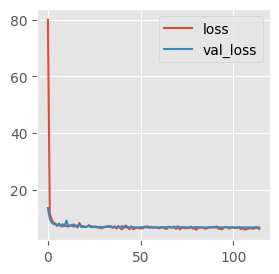

In [39]:
LSTM_result = pd.DataFrame(regressor.history.history)
plt.style.use("ggplot")
LSTM_result.plot(figsize=(3, 3))

In [40]:
y_pred_LSTM = regressor.predict(x_test)
y_pred_LSTM = list(y_pred_LSTM.flatten())


pr,_ = pearsonr(y_test, y_pred_LSTM)
sr,_ = spearmanr(y_test, y_pred_LSTM)

eval_dict = {'test size': 0.25,
              'MAE': '%.3f' %  metrics.mean_absolute_error(y_test, y_pred_LSTM),
              'MSE': '%.3f' % metrics.mean_squared_error(y_test, y_pred_LSTM),
              'RMSE': '%.3f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred_LSTM)),
              'R2 Score': '%.3f' % metrics.r2_score(y_test, y_pred_LSTM),
              'pearson': '%.3f' % pr,
              'spearmanr': '%.3f' % sr,
              }

3/3 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Result of LSTM_model')

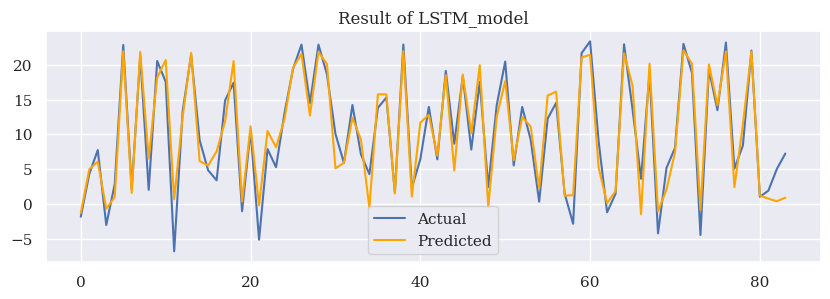

In [41]:
sns.set(font='serif')
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 3

compare = pd.DataFrame({'Actual': y_test.reset_index(drop=True),
                        'Predicted': list(y_pred_LSTM)})
compare = compare.astype(float)
plt.plot(compare.Actual, color='b')
plt.plot(compare.Predicted, color='orange')
plt.legend(['Actual','Predicted'])
plt.title('Result of LSTM_model')

In [42]:
r2 = metrics.r2_score(y_test, y_pred_LSTM)
n = len(y_test)
k = len(x_test.columns)

# calculate adjusted r2 score
adj_r2_score = 1-(((1-r2)*(n-1))/(n-k-1))
adj_r2_score

0.8992383213074274

In [43]:
eval_dict

{'test size': 0.25,
 'MAE': '2.035',
 'MSE': '6.639',
 'RMSE': '2.577',
 'R2 Score': '0.904',
 'pearson': '0.951',
 'spearmanr': '0.945'}

<Axes: xlabel='Predicted', ylabel='Actual'>

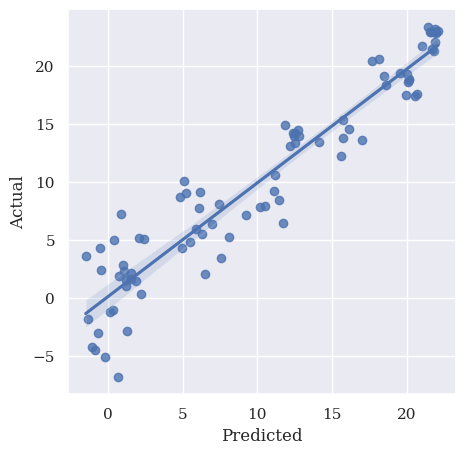

In [44]:
rcParams['figure.figsize'] = 5, 5
sns.regplot(data = compare , y= compare.Actual,x = compare.Predicted)

In [45]:
from sklearn.linear_model import BayesianRidge

def Reg_Ridge_model(x, y, testsize):
  eval = pd.DataFrame()
  for TestSize in testsize:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TestSize, random_state=42)
    model =BayesianRidge(lambda_2=0.0001)
    model.fit(x_train , y_train)
    y_pred = model.predict(x_test)
    corr, _ = pearsonr(y_test, y_pred)
    eval_dict = {'test size': TestSize,
                 'MAE': '%.3f' %  metrics.mean_absolute_error(y_test, y_pred),
                 'MSE': '%.3f' % metrics.mean_squared_error(y_test, y_pred),
                 'RMSE': '%.3f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
                 'R2 Score': '%.3f' % metrics.r2_score(y_test, y_pred),
                 'pearson': '%.3f' % corr
                 }
    eval = eval.append(eval_dict, ignore_index=True)
  return eval
testsize = np.linspace(0.15, 0.35, 9)
result_Reg_Ridge = Reg_Ridge_model(X, y, testsize)
result_Reg_Ridge.style.apply(lambda x: ['background: maroon' if (x.name == 4) else '' for i in x], axis=1)

,test size,MAE,MSE,RMSE,R2 Score,pearson
0,0.150000,1.993,6.678,2.584,0.897,0.947
1,0.175000,1.987,6.524,2.554,0.896,0.948
2,0.200000,2.013,6.746,2.597,0.898,0.949
3,0.225000,1.962,6.434,2.537,0.908,0.954
4,0.250000,1.992,6.705,2.589,0.903,0.951
5,0.275000,1.929,6.358,2.521,0.912,0.956
6,0.300000,1.903,6.138,2.477,0.914,0.957
7,0.325000,1.885,5.935,2.436,0.914,0.956
8,0.350000,1.909,6.078,2.465,0.911,0.955


In [46]:
#ANN
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

In [47]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.6)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)


model = Sequential()
model.add(Dense(32, input_shape=(x.shape[1],), activation = 'sigmoid'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
# model.add(Dense(32, activation = 'relu'))
# model.add(Dense(32, activation = 'relu'))

model.add(Dense(1))
model.compile(optimizer = optimizer, loss='mean_squared_error')
model.fit(x_train, y_train, epochs = 500, batch_size = 1,
              validation_data=(x_test,y_test),
              callbacks=EarlyStopping(monitor='val_loss',patience=5))

y_pred_ANN = model.predict(x_test)
y_pred_ANN = list(y_pred_ANN.flatten())


pr,_ = pearsonr(y_test, y_pred_ANN)
sr,_ = spearmanr(y_test, y_pred_ANN)

eval_dict = {'test size': 0.25,
              'MAE': '%.3f' %  metrics.mean_absolute_error(y_test, y_pred_ANN),
              'MSE': '%.3f' % metrics.mean_squared_error(y_test, y_pred_ANN),
              'RMSE': '%.3f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred_ANN)),
              'R2 Score': '%.3f' % metrics.r2_score(y_test, y_pred_ANN),
              'pearson': '%.3f' % pr,
              'spearmanr': '%.3f' % sr,
              }

Epoch 1/500
252/252 [==============================] - 2s 4ms/step - loss: 78.0940 - val_loss: 19.9549
Epoch 2/500
252/252 [==============================] - 1s 3ms/step - loss: 8.1511 - val_loss: 7.1017
Epoch 3/500
252/252 [==============================] - 1s 3ms/step - loss: 5.9742 - val_loss: 7.0256
Epoch 4/500
252/252 [==============================] - 1s 3ms/step - loss: 5.8773 - val_loss: 6.8385
Epoch 5/500
252/252 [==============================] - 1s 3ms/step - loss: 5.8728 - val_loss: 7.3849
Epoch 6/500
252/252 [==============================] - 0s 2ms/step - loss: 6.2964 - val_loss: 6.8058
Epoch 7/500
252/252 [==============================] - 1s 2ms/step - loss: 5.8895 - val_loss: 6.9402
Epoch 8/500
252/252 [==============================] - 1s 2ms/step - loss: 5.7936 - val_loss: 7.7167
Epoch 9/500
252/252 [==============================] - 1s 2ms/step - loss: 5.8212 - val_loss: 6.5906
Epoch 10/500
252/252 [==============================] - 1s 2ms/step - loss: 5.7228 - val_

In [48]:
eval_dict

{'test size': 0.25,
 'MAE': '2.095',
 'MSE': '7.130',
 'RMSE': '2.670',
 'R2 Score': '0.897',
 'pearson': '0.951',
 'spearmanr': '0.948'}

In [49]:
(eval_dict['R2 Score'])

'0.897'

In [50]:
np.sqrt(0.324)

0.5692099788303083

Text(0.5, 1.0, 'Result of ANN_model')

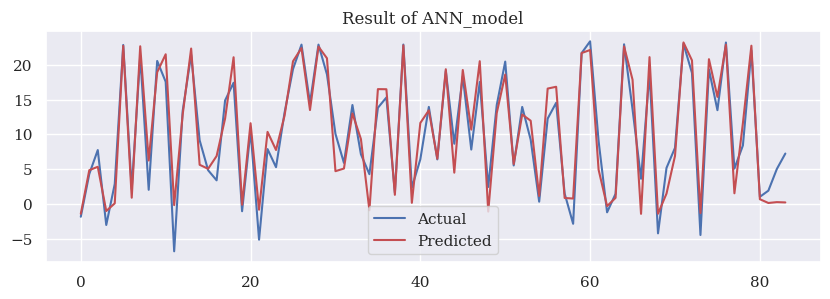

In [51]:
sns.set(font='serif')
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 3

compare_ANN = pd.DataFrame({'Actual': y_test.reset_index(drop=True),
                        'Predicted': list(y_pred_ANN)})
compare_ANN = compare_ANN.astype(float)
plt.plot(compare_ANN.Actual, color='b')
plt.plot(compare_ANN.Predicted, color='r')
plt.legend(['Actual','Predicted'])
plt.title('Result of ANN_model')

<Axes: xlabel='Predicted', ylabel='Actual'>

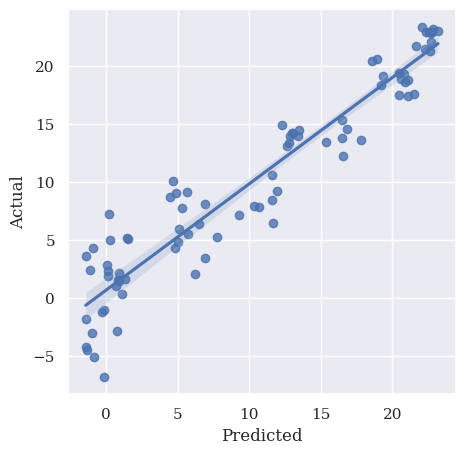

In [52]:
rcParams['figure.figsize'] = 5, 5
sns.regplot(data = compare_ANN , y = compare_ANN.Actual, x = compare_ANN.Predicted)

# **Models**

In [13]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [14]:
model_Extra =ExtraTreesRegressor(n_estimators=m , max_depth=max_d)
model_Extra.fit(x_train , y_train)
y_pred_Extra = model_Extra.predict(x_test)

NameError: ignored

In [ ]:
model_LR =LinearRegression()
model_LR.fit(x_train , y_train)
y_pred_LR = model_LR.predict(x_test)

In [ ]:
model_DT =DecisionTreeRegressor(random_state=42)
model_DT.fit(x_train , y_train)
y_pred_DT = model_DT.predict(x_test)

In [ ]:
model_svr =SVR(C=C, kernel=kernel, gamma=gamma)
model_svr.fit(x_train , y_train)
y_pred_svr = model_svr.predict(x_test)

In [ ]:
model_RF =RandomForestRegressor(n_estimators=n , max_depth=max_depth)
model_RF.fit(x_train , y_train)
y_pred_RF = model_RF.predict(x_test)

In [ ]:
model_AdaB =AdaBoostRegressor(n_estimators=10, random_state=59)
model_AdaB.fit(x_train , y_train)
y_pred_AdaB = model_AdaB.predict(x_test)

In [ ]:
model_KNN = KNeighborsRegressor(metric =metric, n_neighbors= n_neighbors, weights = weights)
model_KNN.fit(x_train , y_train)
y_pred_KNN = model_KNN.predict(x_test)

# **feature_importances**

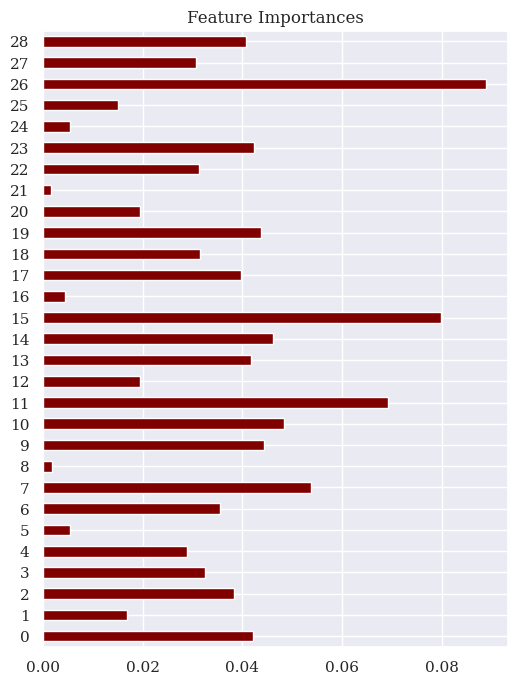

In [ ]:
from matplotlib import rcParams
sns.set()
sns.set(font='serif')
rcParams['figure.figsize'] = 6, 8

feat_importances = pd.Series(model_Extra.feature_importances_, index=x_train.columns)
feat_importances.plot(kind='barh', color='maroon')
plt.title('Feature Importances', fontfamily='serif')
plt.show()

In [ ]:
df = feat_importances.sort_values()
# df.drop(['month', 'year'], inplace=True)
key = list(df.keys())
value = list(df)

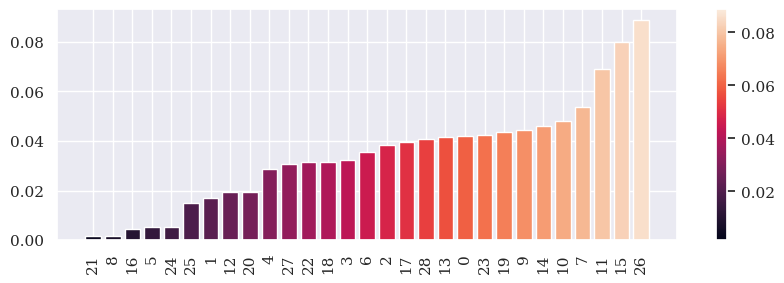

In [ ]:
rcParams['figure.figsize'] = 10, 3
barcontainer = plt.bar(range(len(value)),value, color=sns.color_palette('rocket', len(value)))
ticks = plt.xticks(range(len(key)),key)
plt.xticks(rotation=90)
# plt.title('Chelgerd_st_GCMs_QM')
sm = plt.cm.ScalarMappable(cmap='rocket')
sm.set_clim(vmin=min(value), vmax=max(value))
plt.colorbar(sm)
plt.show()

# **Evaluation**

In [ ]:
def eval_dct(y_test, y_pred):
  eval_dict = {'test size': 0.25,
                'MAE': metrics.mean_absolute_error(y_test, y_pred),
                'MSE':metrics.mean_squared_error(y_test, y_pred),
                'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
                'R2 Score':metrics.r2_score(y_test, y_pred)}
  return eval_dict

In [ ]:
dct_eval = pd.DataFrame()
MAE = []
MSE = []
RMSE = []
r2 = []
names = ['LR', 'svr', 'DT', 'RF','Extra', 'AdaB', 'KNN', 'ANN', 'LSTM']
for index , y_pred in enumerate([y_pred_LR, y_pred_svr, y_pred_DT, y_pred_RF, y_pred_Extra, y_pred_AdaB, y_pred_KNN, compare_ANN.Predicted, y_pred_LSTM]):
  MAE.append(metrics.mean_absolute_error(y_test, y_pred))
  MSE.append(metrics.mean_squared_error(y_test, y_pred))
  RMSE.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  r2.append(metrics.r2_score(y_test, y_pred))
dct_eval.insert(0, 'MAE', MAE)
dct_eval.insert(1, 'MSE', MSE)
dct_eval.insert(2, 'RMSE', RMSE)
dct_eval.insert(3, 'r2', r2)
dct_eval.insert(0, 'model', names)

In [ ]:
dct_eval

,model,MAE,MSE,RMSE,r2
0,LR,2.108507,7.709824,2.776657,0.888622
1,svr,1.938565,5.954391,2.440162,0.913982
2,DT,2.526788,12.514008,3.537514,0.819220
3,RF,1.815467,7.012230,2.648062,0.898700
4,Extra,1.620926,5.701740,2.387832,0.917631
5,AdaB,1.708511,6.197573,2.489492,0.910468
6,KNN,1.727359,5.884681,2.425836,0.914989
7,ANN,2.049668,6.859951,2.619151,0.900900
8,LSTM,1.826436,5.598799,2.366178,0.919119


In [ ]:
compare = pd.DataFrame()
compare.insert(0, 'Actual', y_test)
for index , y_pred in enumerate([y_pred_LR, y_pred_svr, y_pred_DT, y_pred_RF, y_pred_Extra,y_pred_AdaB, y_pred_KNN,y_pred_ANN, y_pred_LSTM]):
  compare.insert(1, names[index], y_pred)

In [ ]:
compare[compare<0] = 0

In [ ]:
compare.reset_index(drop=True, inplace=True)

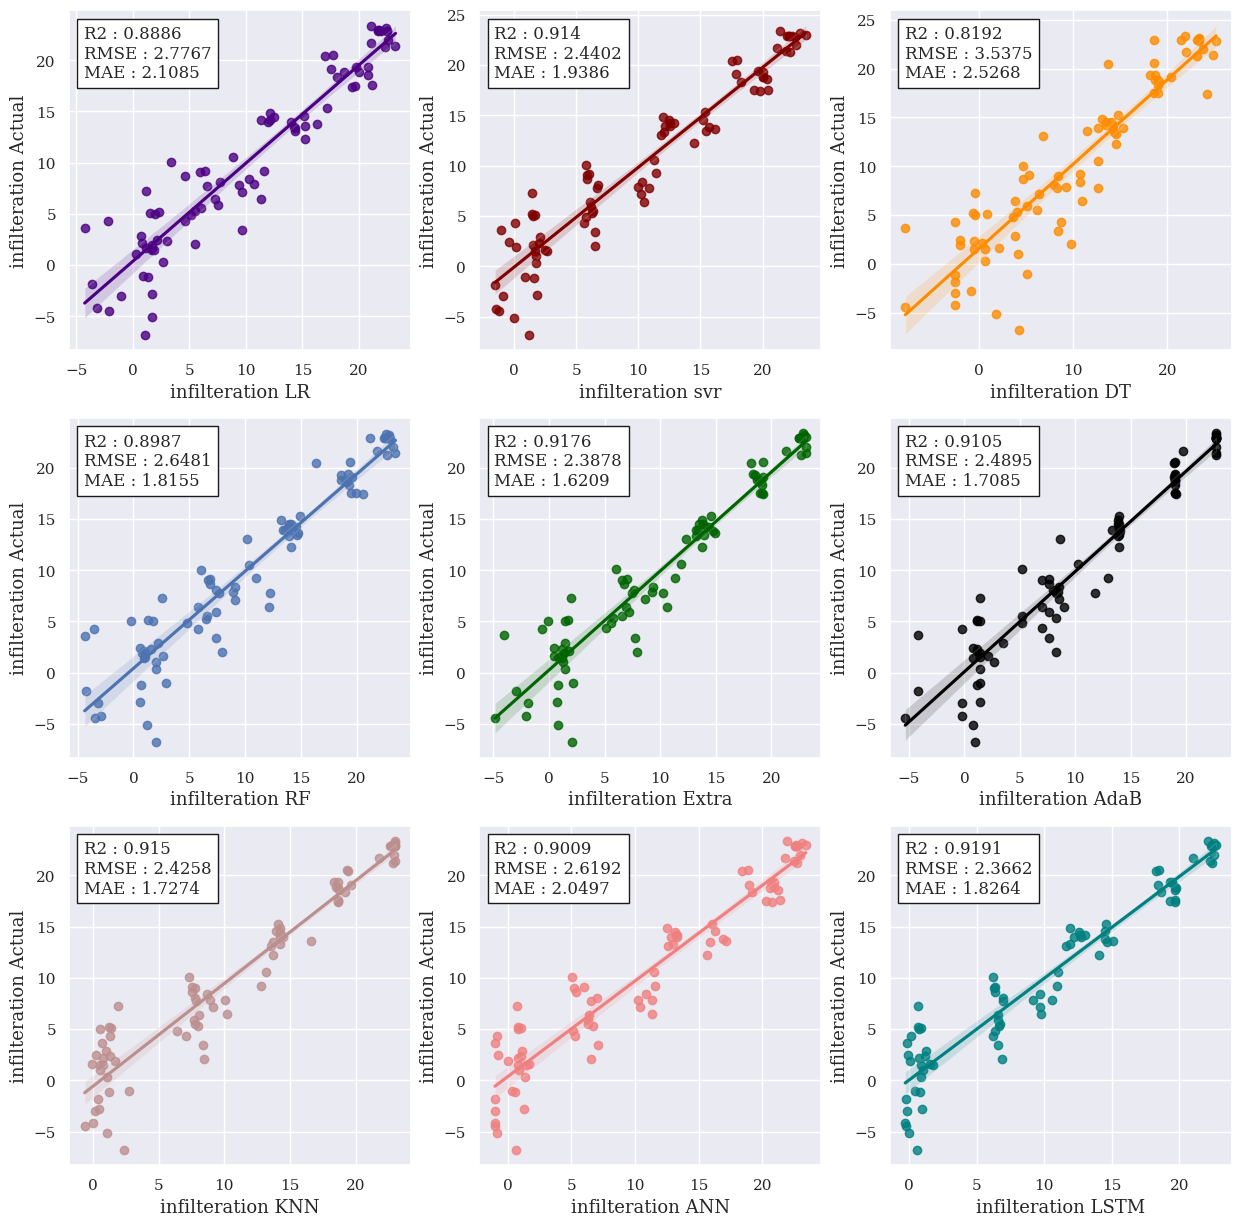

In [ ]:
fig = plt.figure(figsize=(15, 15))
colors = ['indigo', 'maroon', 'darkorange', 'b','darkgreen', 'black', 'rosybrown', 'lightcoral', 'teal']
from matplotlib.offsetbox import AnchoredText
for index, value in enumerate([y_pred_LR, y_pred_svr, y_pred_DT, y_pred_RF, y_pred_Extra, y_pred_AdaB, y_pred_KNN, y_pred_ANN, y_pred_LSTM]):
  plt.subplot(3, 3, index + 1)
  fig = sns.regplot(data = compare, x = value, y = y_test, color= colors[index])
  plt.xlabel('infilteration '+names[index], fontfamily = 'serif', fontsize=13)
  plt.ylabel('infilteration Actual', fontfamily = 'serif', fontsize=13)
  text1 = f'R2 : {np.round(metrics.r2_score(y_test, value), 4)}'+ '\n'+f'RMSE : {np.round(np.sqrt(metrics.mean_squared_error(y_test, value)), 4)}'
  text2 = '\n'+ f'MAE : {np.round(metrics.mean_absolute_error(y_test, value), 4)}'
  text = text1+text2
  anc = AnchoredText(text, loc="upper left", frameon=True, pad=0.4)
  fig.add_artist(anc)
  fig.title.set_size(15)
  fig.title.set_fontweight('bold')
# compare.to_csv('ghale_shahrokh.csv')
# plt.savefig('ghale_shahrokh.png', dpi=300)

# **Scenario Results**

In [ ]:
ssp245 = pd.read_csv('/content/drive/MyDrive/CMIP6_Article/SSP_Folder_Station/st_ssp245/final_ssp245_SAD_ZAYANDEROOD.csv')
ssp245.fillna(0, inplace=True)
date = pd.date_range(end=f'31/12/{2040}', periods=len(ssp245))
ssp245.insert(0, 'Date', date)

In [ ]:
ssp245.insert(1, 'year', ssp245['Date'].dt.year)
ssp245.insert(2, 'month', ssp245['Date'].dt.month)
ssp245.insert(3, 'day', ssp245['Date'].dt.day)
ssp245.drop(['Date'], axis=1, inplace=True)

**Model ExtraTreesRegressor**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
model =ExtraTreesRegressor(n_estimators=m , max_depth=max_d )
model.fit(x_train , y_train)
y_pred = model.predict(x_test)

In [ ]:
ssp245

In [ ]:
ssp245.columns

In [ ]:
df_ssp245 = pd.DataFrame({
        'CNRM-CM6-1': ssp245['CNRM-CM6-1'], 'CanESM5': ssp245['CanESM5'], 'HadGEM3-GC31-LL': ssp245['HadGEM3-GC31-LL'],
        'FGOALS-g3': ssp245['FGOALS-g3'],'BCC-CSM2-MR': ssp245['BCC-CSM2-MR'], 'GISS-E2-1-G': ssp245['GISS-E2-1'],
        'MRI-ESM2': ssp245['MRI-ESM2-0'], 'MIROC6': ssp245['MIROC6'],'CESM2': ssp245['CESM2'],'IPSL-CM6A-LR': ssp245['IPSL-CM6A-LR'],
       'TaiESM1': ssp245['TaiESM1'], 'NorESM2-MM': ssp245['NorESM2-MM'], 'NorEMS2-LM': ssp245['NorESM2-LM'],
       'NESM3': ssp245['NESM3'], 'MPI-ESM1-2-LR': ssp245['MPI-ESM1-2-LR'], 'MPI-ESM1-2-HR': ssp245['MPI-ESM1-2-HR'],
       'MIROC-ES2L': ssp245['MIROC-ES2L'], 'KIOST-EM': ssp245['KIOST-EM'],'KACE-1-0-G': ssp245['KACE-1-0-G'], 'INM-CM5-0': ssp245['INM-CM5-0'],
       'INM-CM4-8': ssp245['INM-CM4-8'],'IITM-ESM': ssp245['IITM-ESM'], 'GFDL-ESM4': ssp245['GFDL-ESM4'],'EC-Earth3-Veg-LR': ssp245['EC-Earth3-Veg-LR'],
        'EC-Earth3': ssp245['EC-Earth3'], 'CMC-CM2-SR5': ssp245['CMC-CM2-SR5'], 'CMC-ESM2': ssp245['CMC-ESM2'], 'ACESS-ESM1-5': ssp245['ACESS-ESM1-5'],
        'ACCESS-CM2': ssp245['ACCESS-CM2'], 'UKESM-0-LL': ssp245['UKESM-0-LL']
})
df_ssp245.insert(0, 'year', ssp245.year)
df_ssp245.insert(1, 'month', ssp245.month)
df_ssp245.insert(2, 'day', ssp245.day)
df_ssp245

In [ ]:
df_m_ssp245 = df_ssp245.groupby(['year', 'month']).agg({
        'CNRM-CM6-1':np.sum, 'CanESM5':np.sum , 'HadGEM3-GC31-LL':np.sum ,
        'FGOALS-g3':np.sum,'BCC-CSM2-MR':np.sum , 'GISS-E2-1-G':np.sum,
        'MRI-ESM2':np.sum , 'MIROC6':np.sum ,'CESM2':np.sum,'IPSL-CM6A-LR':np.sum ,
       'TaiESM1':np.sum , 'NorESM2-MM':np.sum, 'NorEMS2-LM':np.sum ,
       'NESM3':np.sum , 'MPI-ESM1-2-LR':np.sum, 'MPI-ESM1-2-HR':np.sum,
       'MIROC-ES2L':np.sum, 'KIOST-EM':np.sum,'KACE-1-0-G':np.sum , 'INM-CM5-0':np.sum ,
       'INM-CM4-8':np.sum,'IITM-ESM':np.sum, 'GFDL-ESM4':np.sum,'EC-Earth3-Veg-LR':np.sum ,
        'EC-Earth3':np.sum , 'CMC-CM2-SR5':np.sum , 'CMC-ESM2':np.sum, 'ACESS-ESM1-5':np.sum ,
        'ACCESS-CM2': np.sum, 'UKESM-0-LL': np.sum

})
df_m = df_m_ssp245.index.get_level_values('month')
df_y = df_m_ssp245.index.get_level_values('year')

df_m_ssp245.insert(0, 'month',df_m)
df_m_ssp245.insert(0, 'year',df_y)

df_m_ssp245.reset_index(drop=True, inplace=True)
df_m_ssp245['target_pr'] = 0

In [ ]:
from sklearn.decomposition import PCA

x = data.drop(['year', 'month', 'obs'], axis=1)
y = data['obs']

pca = PCA(n_components=0.95)
X_pca = pca.fit(BC)
X_pca = pca.transform(BC)
print("original shape:   ", BC.shape)
print("transformed shape:", X_pca.shape)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [ ]:
X_pred = df_m_ssp245.drop(['year','month', 'target_pr'], axis=1)
y_pred = df_m_ssp245.target_pr

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.95)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model = Sequential()
model.add(Dense(32, input_shape=(x.shape[1],), activation = 'relu'))
model.add(Dense(32, activation = 'relu'))


model.add(Dense(1))
model.compile(optimizer = optimizer, loss='mean_squared_error')
model.fit(x, y, epochs = 500, batch_size = 32,
              # validation_data=(X_pred,y_test),
              callbacks=EarlyStopping(monitor='loss',patience=5))

y_pred_ANN_ssp585 = model.predict(X_pred)

In [ ]:
com = pd.DataFrame({
    'year': df_m_ssp245.year,
    'month': df_m_ssp245.month,
    'obs':list(y_pred_ANN_ssp585)
    })
com.obs[com.obs < 0] = 0
hst = data[['year', 'month', 'obs']]

In [ ]:
lst_df = [hst, com]

In [ ]:
df_n = pd.concat(lst_df)
df_n.obs = df_n.obs.astype(float)
df_n.to_csv('ssp245.csv')

In [ ]:
sns.heatmap(df_n.corr(), annot=True)

In [ ]:
rcParams['figure.figsize'] = 19, 3
df_n.obs.plot()

In [ ]:
df_n.describe()